In [1]:
import helicity_model_1d
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from hist_utils import calc_one_chi2, HistMaker1d, geom_avg1d, ratio_err, symmetrize
from hist_template import set_opt_text, set_th1, set_pad
from fitting import covariance_fit_scipy
from helicity_model_1d import fit_simple, Helicity1d
from plotting import plotComparison, xAxisProperties
from ROOT import TFile, TH1, TF1, TCanvas, gStyle, TLegend
import math
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
gStyle.SetOptStat(0)

same_sign_symm = False
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = False
range_used = range(0,12)
fraction = 0.8

if read_saved:
    if event_mixing:
        if ag1580ag:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d_ag1580ag"
        else:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d"
    else:
        if ag1580ag:
           # DIR_NAME = "results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr_vertexsim_epem"
            DIR_NAME = "results_1702372287"
        else:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
ag1580ag = True

if ag1580ag:
    ekin = 1580
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
   # filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
   # filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
   # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp.dat"
   # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn.dat"
    filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np_newCuts.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_newCuts.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_newCuts.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
        filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
        filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
        filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_swapRandomly.dat"
        filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_swapRandomly.dat"
else:
    ekin = 1230
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "088_090_ag123ag_2500A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0 = "mar19_diele_inmedium_heli0cm_np.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"


frame = Frame.HX

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMaker1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMaker1d(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMaker1d(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists  ()
histMakerData_pp = HistMaker1d(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMaker1d(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_np_mix = HistMaker1d(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMaker1d(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMaker1d(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_heli0 = HistMaker1d(filename_MC_rho_heli0, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli0_pp = HistMaker1d(filename_MC_rho_heli0_pp, "_MC_rho_heli0_pp", bins, frame, ekin)
histMakerMC_rho_heli0_nn = HistMaker1d(filename_MC_rho_heli0_nn, "_MC_rho_heli0_nn", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMaker1d(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_rho = histMakerMC_rho_heli0
histMakerMC_pi0 = HistMaker1d(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMaker1d(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMaker1d("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMaker1d("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        return histMakerMC_pi0 if hist_index < 3 else histMakerMC_rho
        # return histMakerMC_rho

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11


Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_data_

Info in <TCanvas::Print>: gif file results_1703367346/base_hists_pi0_MC.gif has been created


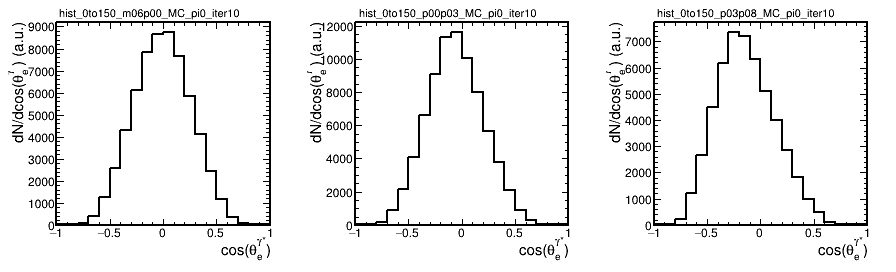

In [4]:
base_hists_pi0 = get_hist_maker_mc(0).builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        pad = can3.cd(i+1)
        set_pad(pad)

        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_1703367346/base_hists_rho_MC.gif has been created


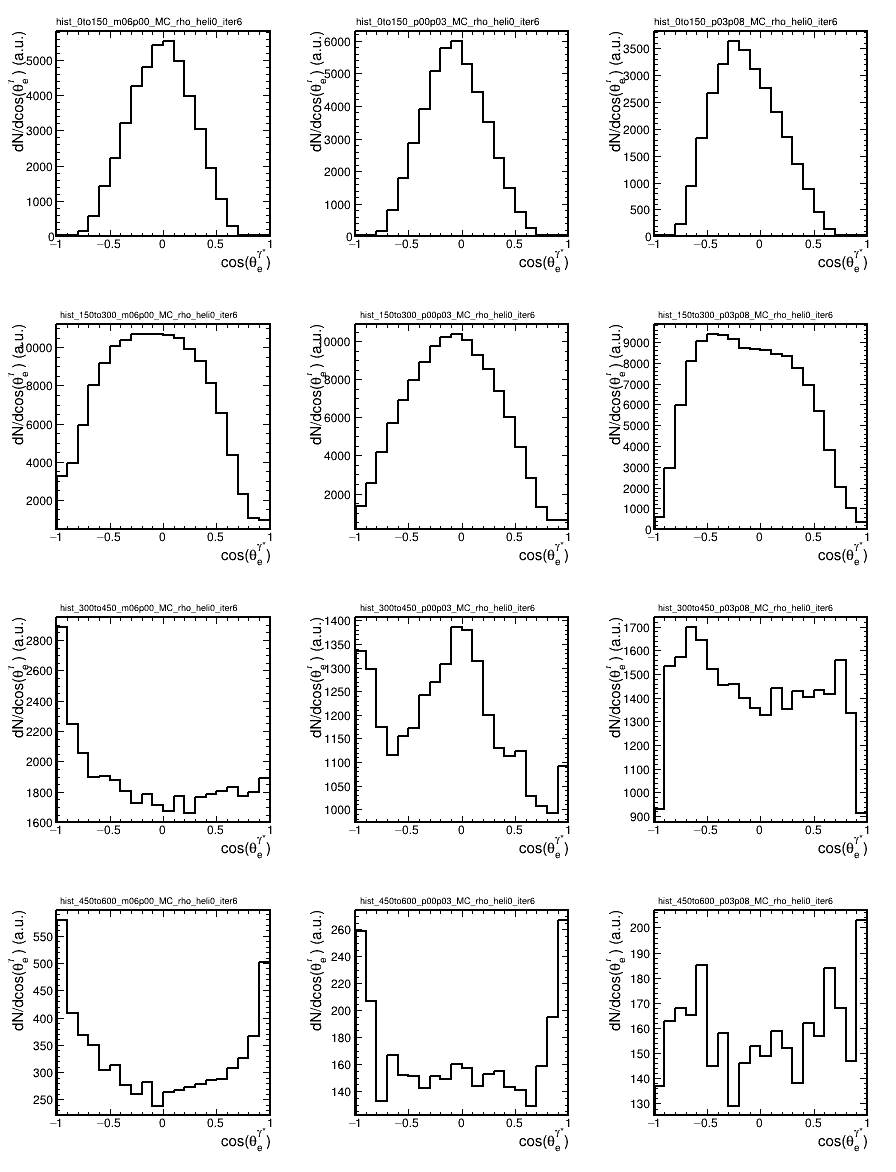

In [5]:
base_hists_rho = get_hist_maker_mc(3).builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    pad = can5.cd(i+1)
    set_pad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        set_th1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


In [6]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [7]:
TH1.SetDefaultSumw2()

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [8]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [9]:
parameters_all = []
losses_all = [[]]* len(range_used)

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        simple_model = Helicity1d()
        hist_data_simple = histsData_np[0][HIST_INDEX]
        hist_mc_simple = get_hist_maker_mc(HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
        if HIST_INDEX == 2:
            losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01)
        else:
            losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01)
        parameters_all.append([param for param in simple_model.parameters()])
        losses_all[HIST_INDEX] = losses

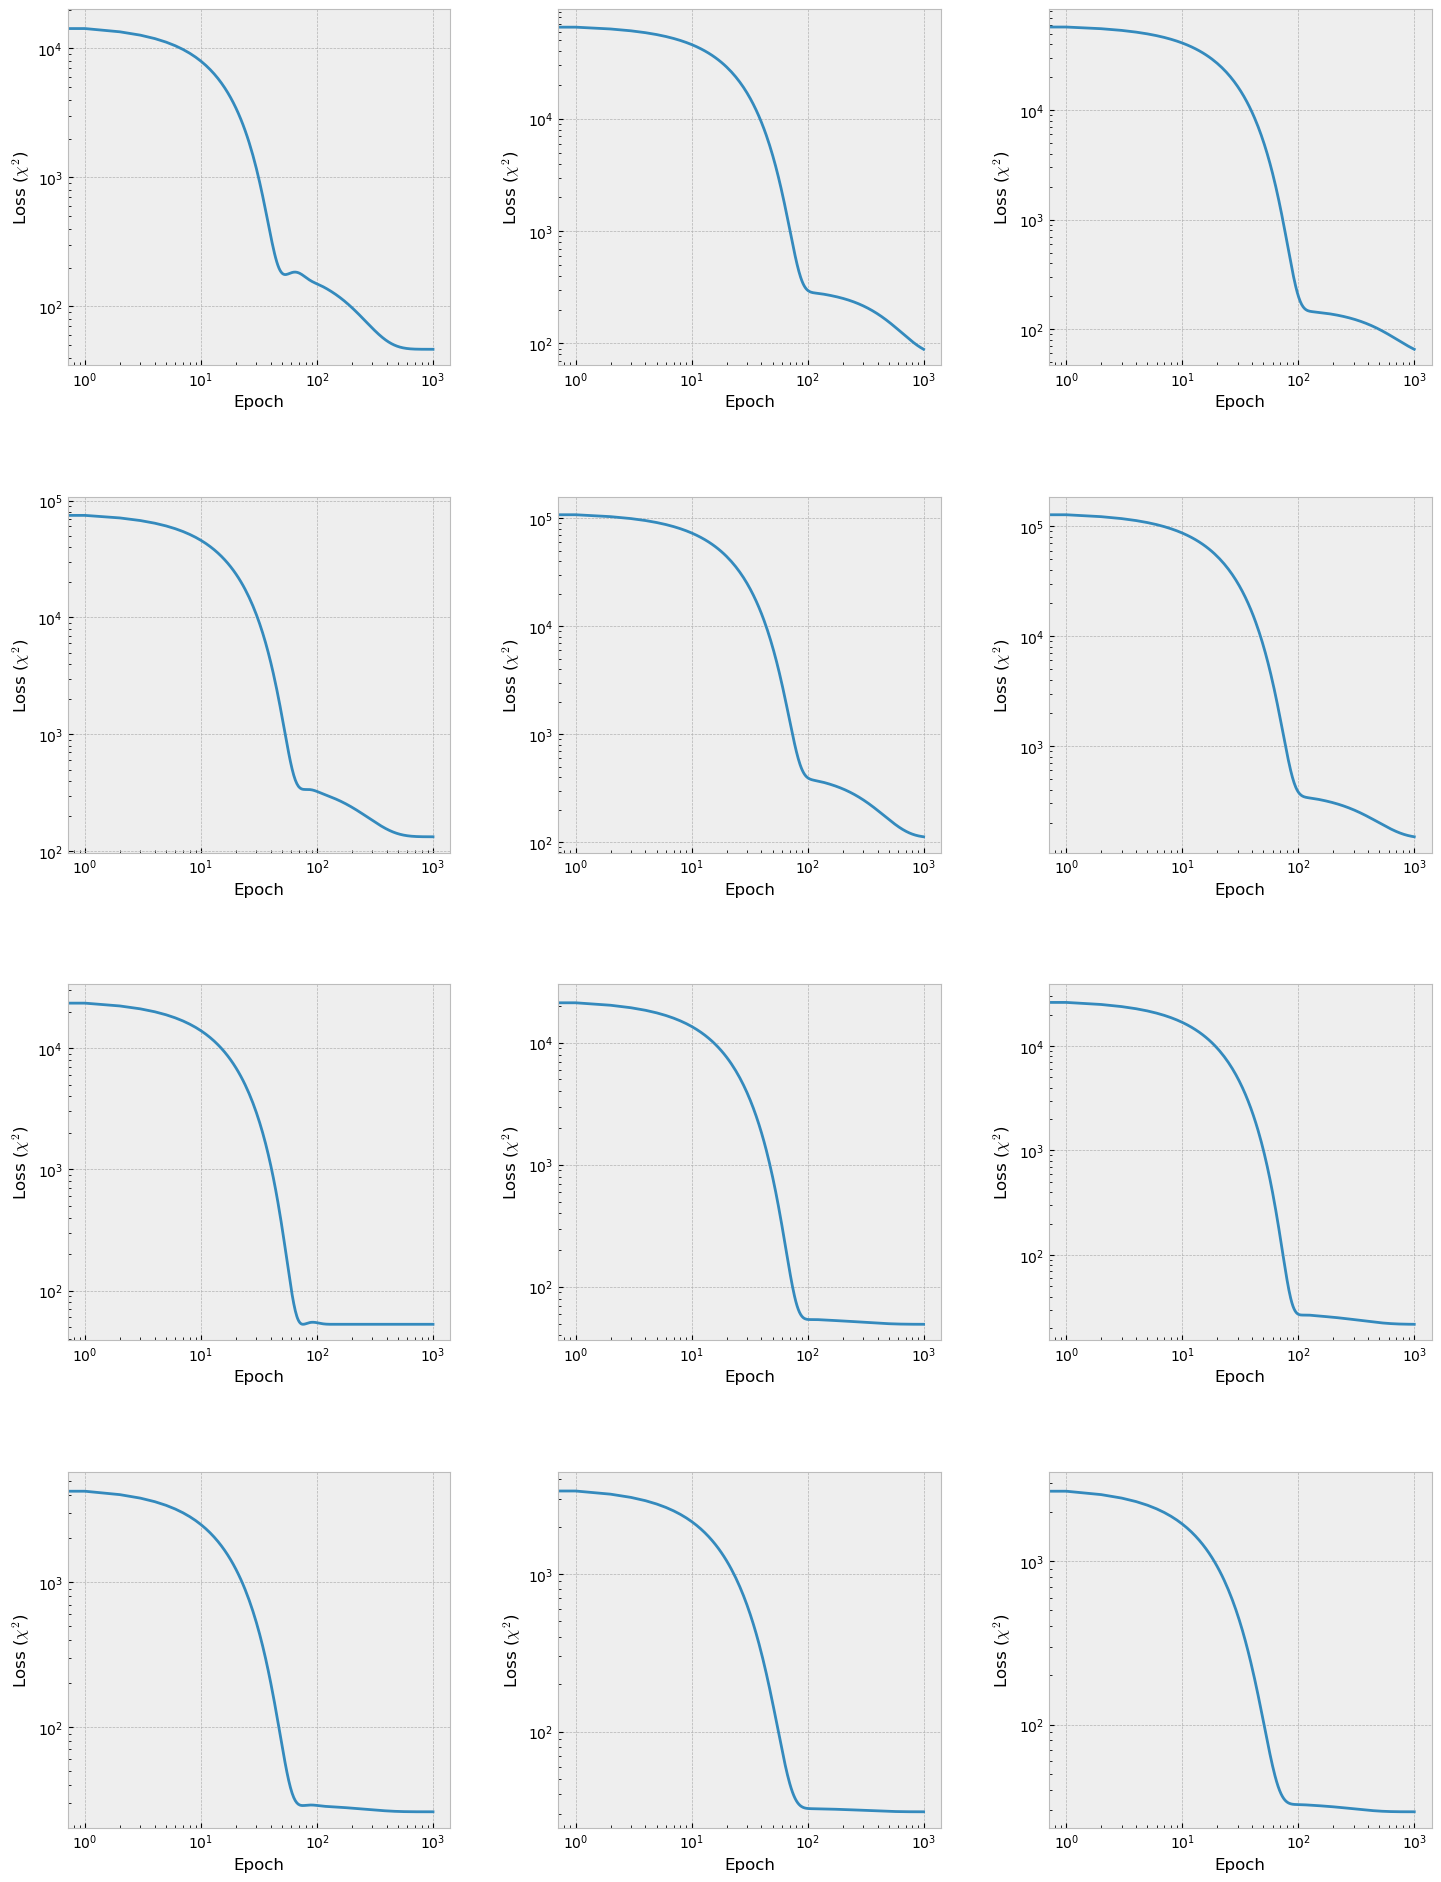

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=3)
fig.tight_layout()
fig.set_figheight(20)
fig.set_figwidth(15)
for HIST_INDEX in range_used:
    # print(losses_all[HIST_INDEX])
    ax[HIST_INDEX // 3][HIST_INDEX % 3].plot(losses_all[HIST_INDEX])
    ax[HIST_INDEX // 3][HIST_INDEX % 3].set_xlabel("Epoch")
    ax[HIST_INDEX // 3][HIST_INDEX % 3].set_ylabel("Loss ($\chi^2$)")
    ax[HIST_INDEX // 3][HIST_INDEX % 3].set_xscale("log")
    ax[HIST_INDEX // 3][HIST_INDEX % 3].set_yscale("log")

0. Final result: lambda_theta =  1.500989556312561  +-  0.9474733734406788
1. Final result: lambda_theta =  1.3993375301361084  +-  0.39936729971222173
2. Final result: lambda_theta =  1.050283432006836  +-  0.15515509025563431
3. Final result: lambda_theta =  0.9282598495483398  +-  0.03369222617580829
4. Final result: lambda_theta =  1.0012927055358887  +-  0.048387519925710866
5. Final result: lambda_theta =  0.8855412006378174  +-  0.08554919400397316
6. Final result: lambda_theta =  0.6020649075508118  +-  0.03596721891949966
7. Final result: lambda_theta =  0.646643877029419  +-  0.04572040642638937
8. Final result: lambda_theta =  0.63960200548172  +-  0.028322135643828284
9. Final result: lambda_theta =  0.4869880974292755  +-  0.059050947064895304
10. Final result: lambda_theta =  0.4239693284034729  +-  0.1037585431975223
11. Final result: lambda_theta =  0.37300702929496765  +-  0.09475596527173355


Info in <TCanvas::Print>: gif file results_1703367346/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_1703367346/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_1703367346/comparison_8.gif has been created
Info in <TCanvas::Print>: gif file results_1703367346/comparison_11.gif has been created


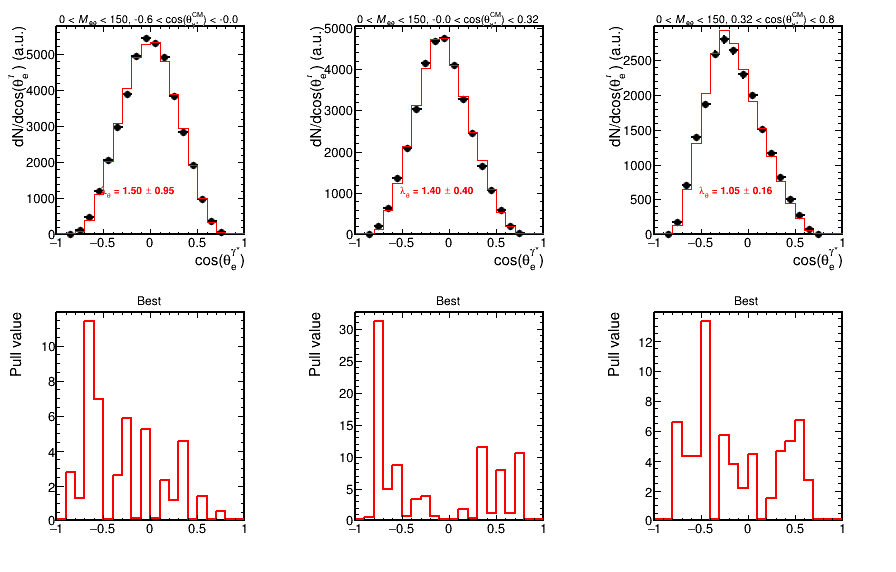

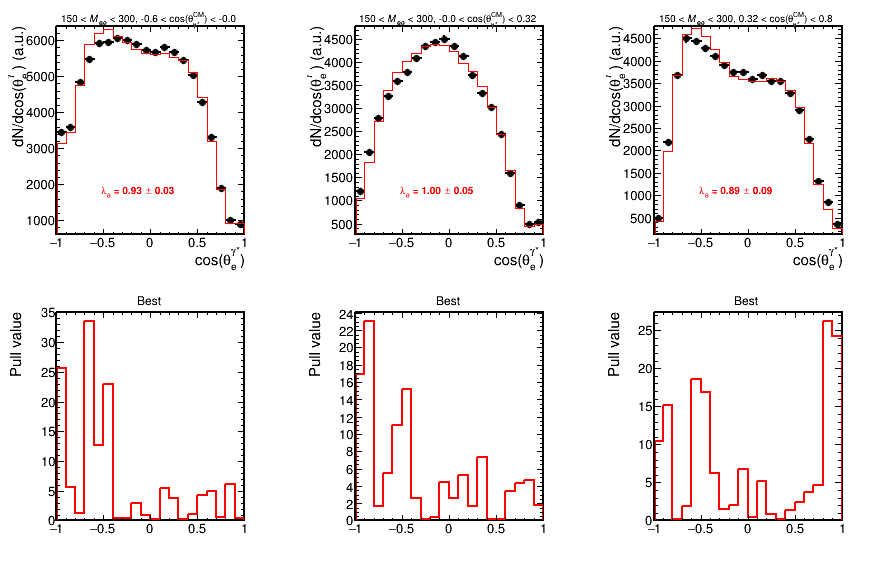

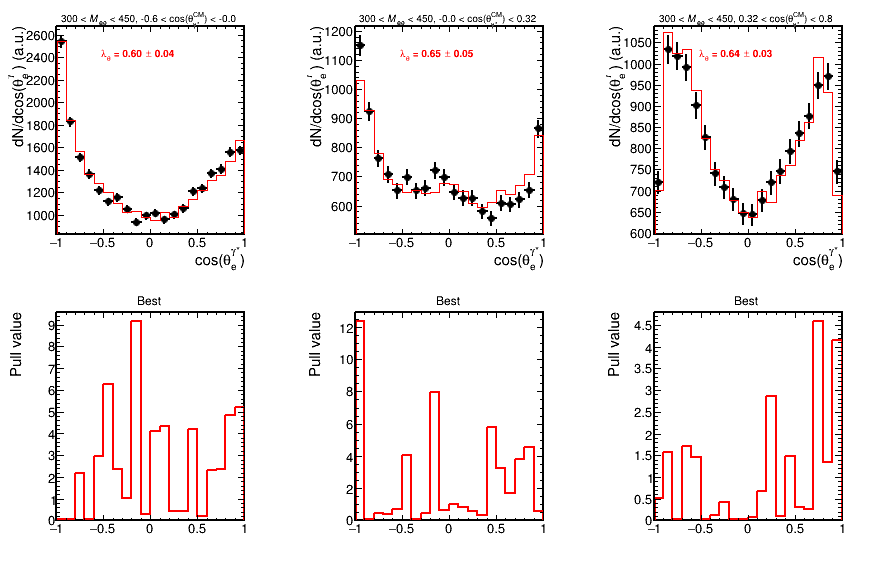

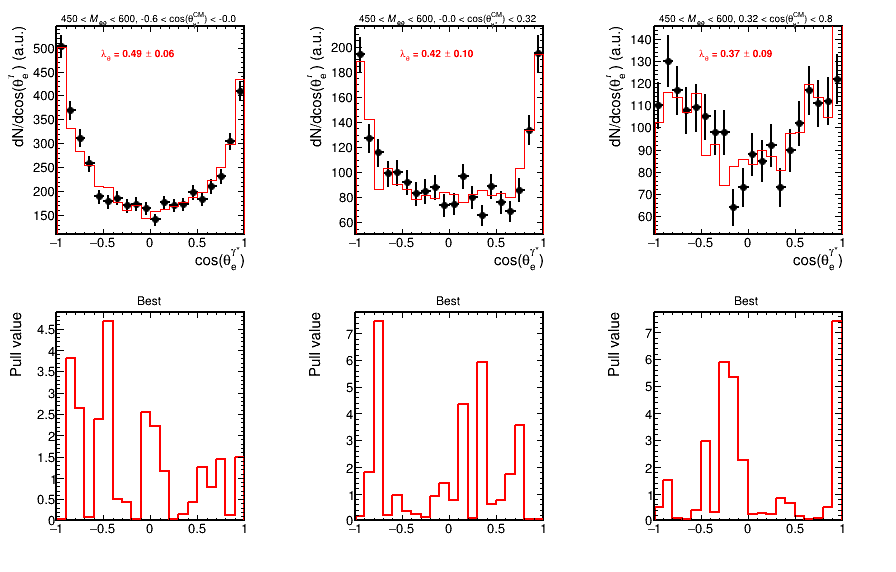

In [11]:
with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    paveTexts = []
        
    for HIST_INDEX in range_used:

       # ax = plt.axes()
       # fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = parameters_all[HIST_INDEX][0].item()
        bestHistsMC = get_hist_maker_mc(HIST_INDEX).make_hists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        if HIST_INDEX % 3 == 0:
            can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",900,600)
            can1.Divide(3,2)
            can1.Draw()        
            canvases.append(can1)
        
        hdiff1 = plotComparison(can1, HIST_INDEX % 3 + 1, HIST_INDEX % 3 + 4, bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Best", bins)
        hdiffs.append(hdiff1)
    
        n, meanX2, varX2, sigma2 = xAxisProperties(bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
        errB0 = math.sqrt(sigma2 * (1/n + meanX2 * meanX2 / varX2))
        errB1 = math.sqrt(sigma2 / varX2)
        ratio_error = ratio_err(lambda_theta, 1, errB1, errB0)
        
        can1.cd(HIST_INDEX % 3 + 1)
        
        caption = f"#lambda_{{#theta}} = {lambda_theta:.2f} #pm {ratio_error:.2f}"
        if HIST_INDEX < 6:
            paveText = set_opt_text(caption, 0.25,0.26,0.675,0.38, 2, 0.04)
        else:
            paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)    
        paveTexts.append(paveText)

        if HIST_INDEX % 3 == 2:
            can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")
    
        try:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", lambda_theta, " +- ", ratio_error)
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", lambda_theta, " +- ", ratio_error, file=fout)
        except:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", lambda_theta)
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", lambda_theta, file=fout)


Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_mix_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_iter2_corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_mix_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_iter2_corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_iter2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_mix_iter5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_iter2_corr (Potenti

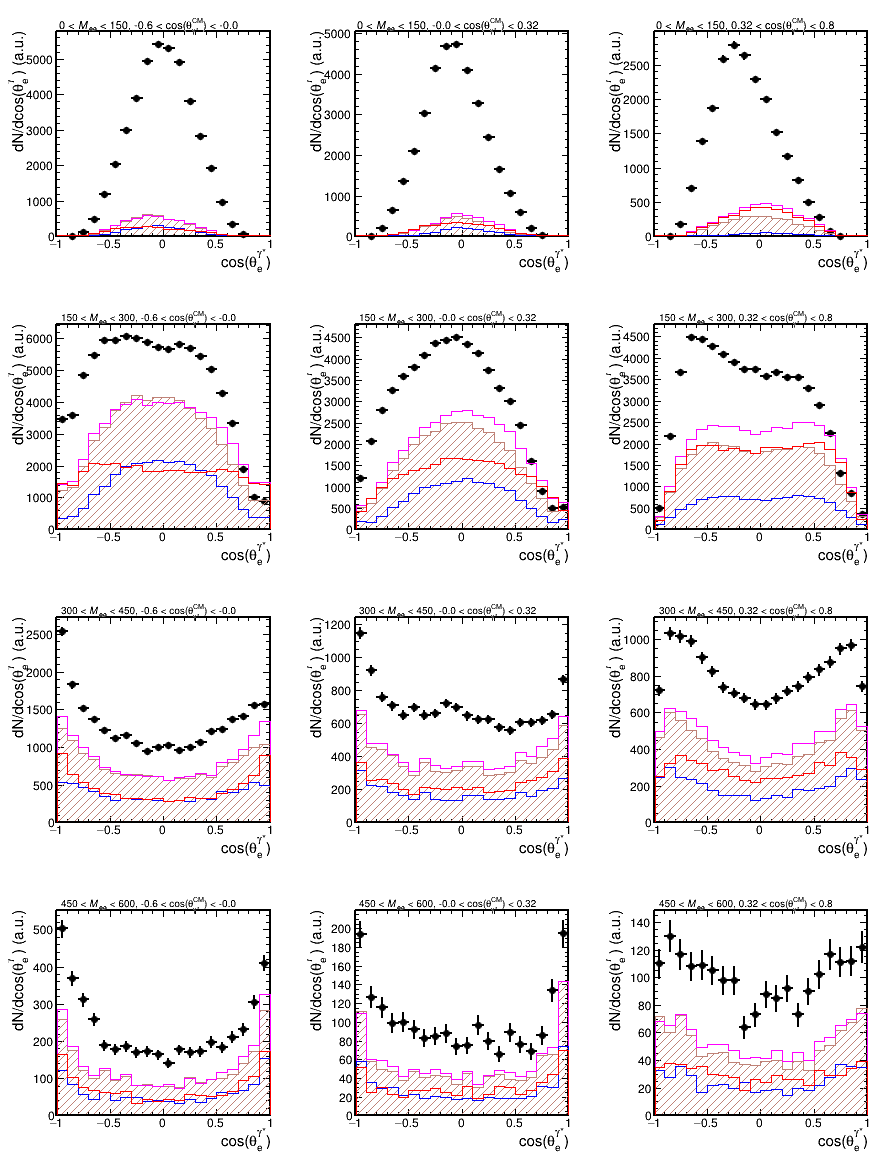

In [12]:
histsDataCorrs = []
histsDatas = []
histsModels = []
hmodel_null = histMakerMC_rho.make_hists((0.0))
hmodel_null_pp = histMakerMC_rho_heli0_pp.make_hists((0.0))
hmodel_null_nn = histMakerMC_rho_heli0_nn.make_hists((0.0))
hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

pol2s = []
histsAvg = []
kfactors = []

cc4 = TCanvas("cc4","cc4",900,1200)
cc4.Divide(3,4)
cc4.Draw()

cck = TCanvas("cck","cck",900,1200)
cck.Divide(3,4)

csig = TCanvas("csig","csig",900,1200)
csig.Divide(3,4)

cacc = TCanvas("cacc","cacc",900,1200)
cacc.Divide(3,4)

for i, hist_np in enumerate(histsData_np[0]):
    
    if not isinstance(hist_np, list):

        hist_pp = histsData_pp[0][i]
        hist_nn = histsData_nn[0][i]
        
        if symmetrize_explicit:
            symmetrize(hist_np)
            symmetrize(hist_pp)
            symmetrize(hist_nn)
        
        histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
        histsAvg.append(histAvg)

        
        histCorr_np = hist_np.Clone(hist_np.GetName() + "_corr")
        histCorr_pp = hist_pp.Clone(hist_pp.GetName() + "_corr")
        histCorr_nn = hist_nn.Clone(hist_nn.GetName() + "_corr")
        histsDataCorrs.append(histCorr_np)
        histsDataCorrs.append(histCorr_pp)
        histsDataCorrs.append(histCorr_nn)
        histCorr_np.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        pad = cc4.cd(i+1)
        set_pad(pad)       
       
        hist_kfactor = histsData_np_mix[0][i]
        hist_pp_mix = histsData_pp_mix[0][i]
        hist_nn_mix = histsData_nn_mix[0][i]

        if symmetrize_explicit:
            symmetrize(hist_kfactor)
            symmetrize(hist_pp_mix)
            symmetrize(hist_nn_mix)

        histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
        hist_kfactor.Divide(histAvg_mix)
        hist_kfactor.Scale(2)
        kfactors.append(hist_kfactor)

        pad = cck.cd(i+1)
        set_pad(pad)

        hist_kfactor.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        set_th1(hist_kfactor, histCorr_np.GetXaxis().GetTitle(), "#it{k}-factor", 
               505, 20, 0.8, 1)
        hist_pp_mix.SetLineColor(2)
        hist_nn_mix.SetLineColor(4)
        hist_pp_mix.SetMarkerColor(2)
        hist_nn_mix.SetMarkerColor(4)
        hist_kfactor.Draw()
        hist_pp_mix.Draw("SAME")
        hist_nn_mix.Draw("SAME")
        hist_kfactor.SetMinimum(0)
         
        pad = cc4.cd(i+1)
        set_pad(pad)       
        
        histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
        histsAvg.append(histAvg_withK)
        histAvg_withK.Multiply(hist_kfactor)
        
        histAvg_withK.SetFillStyle(3004)
        histAvg_withK.SetFillColor(45)
        histAvg_withK.SetLineColor(45)
        histAvg.SetLineColor(6)
        hist_pp.SetLineColor(4)
        hist_nn.SetLineColor(2)
                
        set_th1(hist_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist_np.SetMinimum(0)
        hist_np.Draw()
        histAvg_withK.Draw("SAMEHIST")
        histAvg.Draw("SAMEHIST")
        hist_pp.Draw("SAMEHIST")
        hist_nn.Draw("SAMEHIST")
        
        pad = csig.cd(i+1)
        set_pad(pad)     

        hist_model_np = hmodel_null_mix[0][i]
        # TODO: make it consistent if we go the way of using mixing
        hist_model_pp = hmodel_null_mix[0][i]
        hist_model_nn = hmodel_null_mix[0][i]
        if not event_mixing:
            if i < 3:
                hist_model_np = hmodel_null_pi0[0][i]
                # TODO: make is consisnt if combinatorial background really matters for the pi0 region
                hist_model_pp = hmodel_null_pi0[0][i]
                hist_model_nn = hmodel_null_pi0[0][i]
            else:
                hist_model_np = hmodel_null[0][i]
                hist_model_pp = hmodel_null_pp[0][i]
                hist_model_nn = hmodel_null_nn[0][i]
        if symmetrize_explicit:
            symmetrize(hist_model_np)

       # histCorr_np.Add(histAvg_withK,-1)
        histCorr_np.Divide(hist_model_np)
        histCorr_pp.Divide(hist_model_pp)
        histCorr_nn.Divide(hist_model_nn)
        
        histAvgCorr = geom_avg1d(histCorr_pp, histCorr_nn, 0.2)
        histsAvg.append(histAvgCorr)
        histAvgCorr_withK = histAvgCorr.Clone(histAvgCorr.GetName() + "_withK")
        histsAvg.append(histAvgCorr_withK)
        histAvgCorr_withK.Multiply(hist_kfactor)
    
        s2b = (hist_np.Integral() - histAvg_withK.Integral()) / histAvg_withK.Integral()
        s2b_corr = (histCorr_np.Integral() - histAvgCorr_withK.Integral()) / histAvgCorr_withK.Integral()
        histCorr_pp.Scale(s2b/s2b_corr)
        histCorr_nn.Scale(s2b/s2b_corr)
        histAvgCorr.Scale(s2b/s2b_corr)
        histAvgCorr_withK.Scale(s2b/s2b_corr)
    
        histAvgCorr_withK.SetFillStyle(3004)
        histAvgCorr_withK.SetFillColor(45)
        histAvgCorr_withK.SetLineColor(45)
        histAvgCorr.SetLineColor(6)

        #if symmetrize_explicit:    
            #symmetrize(histCorr_np)

        fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1.0,1.0)
        fit.SetParameters(1, 1)
        
        histCorr_np.Fit(fit,"Q")
        pol2s.append(fit)
    
        set_th1(histCorr_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
    
        histCorr_pp.SetLineColor(4)
        histCorr_nn.SetLineColor(2)
        histCorr_np.Draw()
        histCorr_pp.Draw("SAMEHIST")
        histCorr_nn.Draw("SAMEHIST")
        histAvgCorr.Draw("SAMEHIST")
        histAvgCorr_withK.Draw("SAMEHIST")
        if i < 3:
            # histCorr_np.GetYaxis().SetRangeUser(0,2.5)
            histCorr_np.GetYaxis().SetRangeUser(0,20)
        else:
            # histCorr_np.GetYaxis().SetRangeUser(0,1.25)    
            histCorr_np.GetYaxis().SetRangeUser(0,2)    
        histCorr_np.SetMinimum(0)
        
        caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
        paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
        paveTexts.append(paveText)

        pad = cacc.cd(i+1)
        set_pad(pad)
        
        hacc_heli0 = hmodel_null[0][i]
        hacc_heli1 = hmodel_null_heli1[0][i]

    else:
        print(hist_np)

cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
    


Info in <TCanvas::Print>: gif file results_1703367346/kfactor.gif has been created
Info in <TCanvas::Print>: gif file results_1703367346/signal.gif has been created


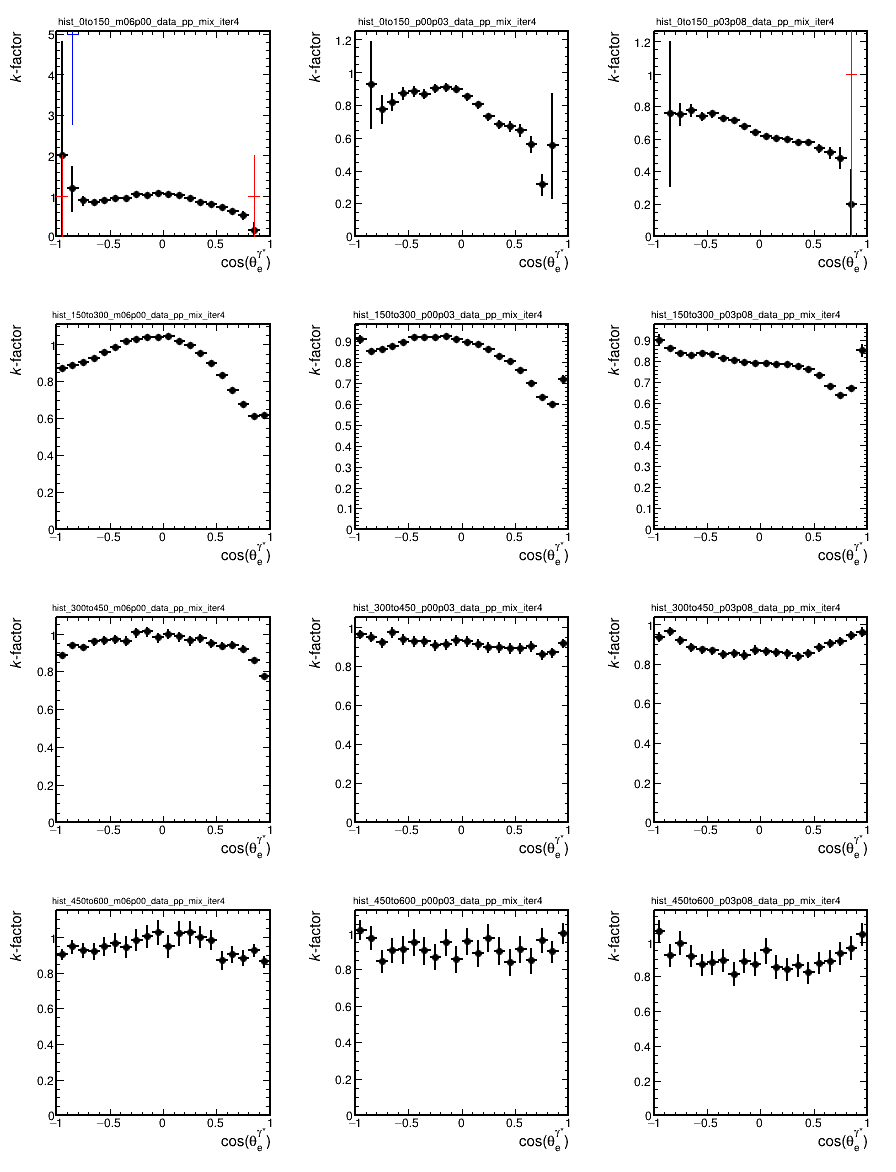

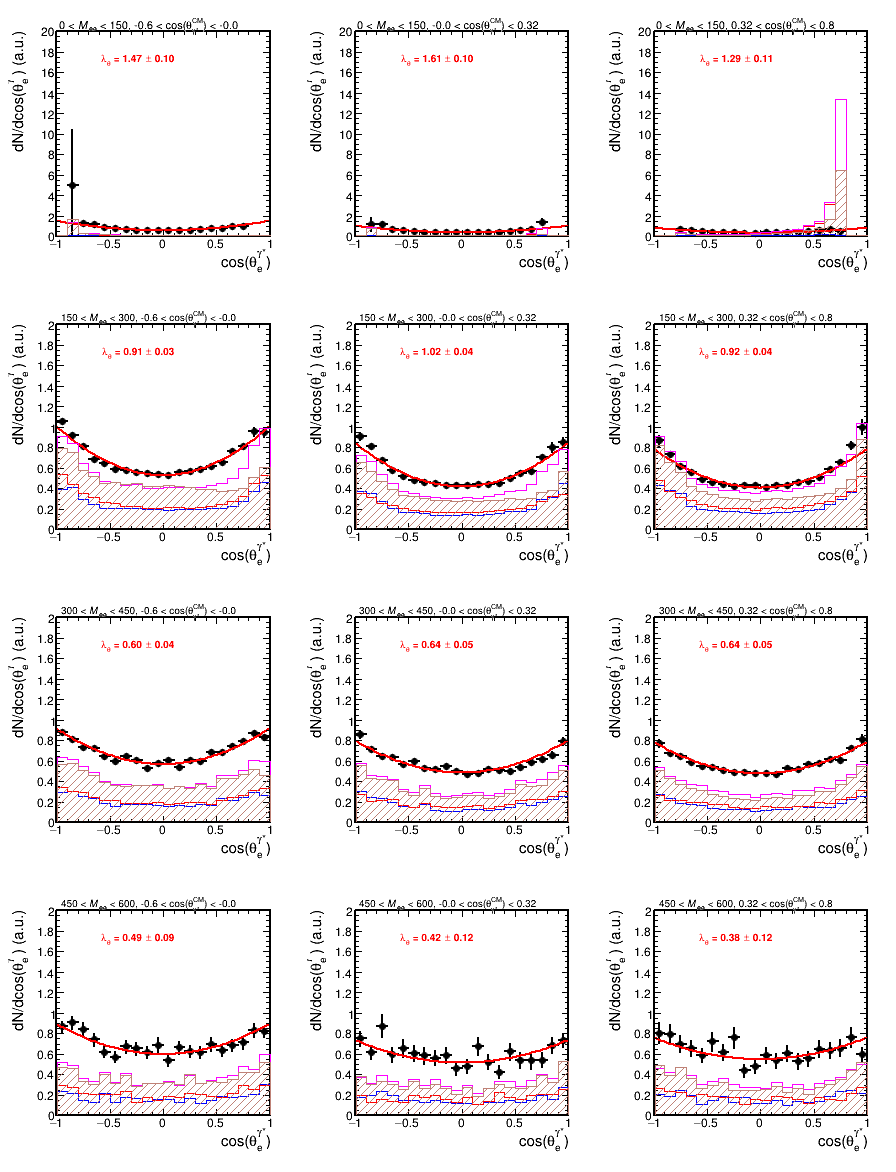

In [13]:
cck.Draw()
cck.SaveAs(f"{DIR_NAME}/kfactor.gif")

csig.Draw()
csig.SaveAs(f"{DIR_NAME}/signal.gif")

Info in <TCanvas::Print>: gif file results_1703367346/cmp_mass_z.gif has been created


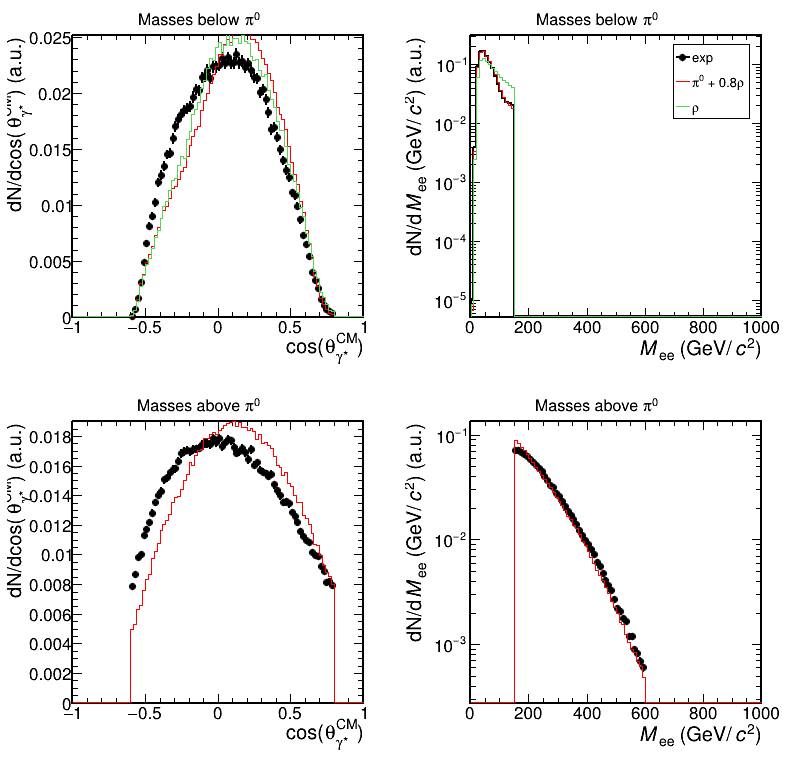

In [14]:
hmodelLowM_rho = histMakerMC_mix.make_hists(0.0) if event_mixing else histMakerMC_rho.make_hists(0.0)
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.make_hists(0.0)

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = get_hist_maker_mc(3).make_hists(0.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

pad = cc.cd(1)
set_pad(pad)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")

set_th1(histsData_np[2][0], histsData_np[2][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
set_pad(pad)
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")

set_th1(histsData_np[1][0], histsData_np[1][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], f"#pi^{{0}} + {fraction}#rho", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

pad = cc.cd(3)
set_pad(pad)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[2][1], histsData_np[2][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
#hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
set_pad(pad)
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[1][1], histsData_np[1][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
#hmodelLowM_rho[1][1].Draw("SAMEHIST")

cc.SaveAs(f"{DIR_NAME}/cmp_mass_z.gif")

ASImage2gif():1010:<results_1703367346/cacc.gif> 
GIF-LIB undefined error 0.
Error in <TASImage::WriteImage>: error writing file results_1703367346/cacc.gif


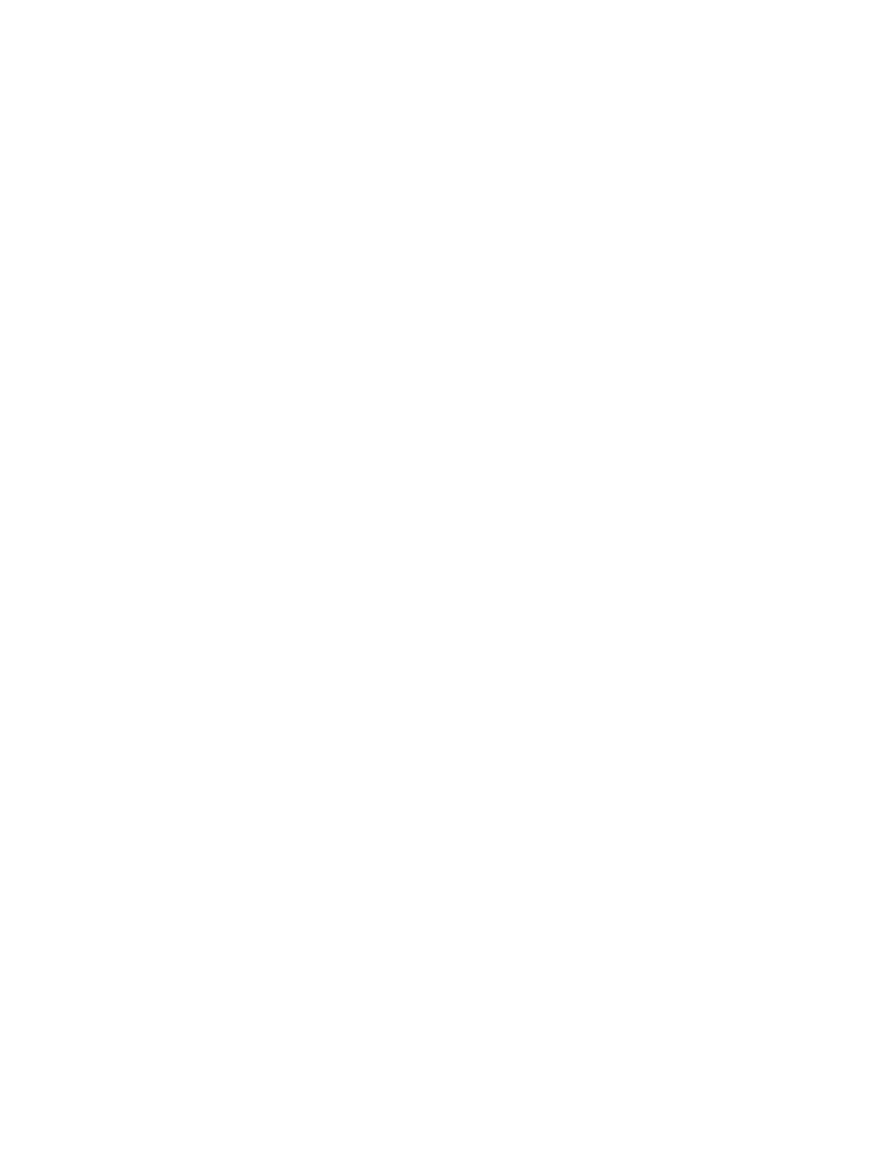

In [15]:
cacc.Draw()
cacc.SaveAs(f"{DIR_NAME}/cacc.gif")
